In [28]:
%matplotlib inline

In [1]:
import pyspark
sc = pyspark.SparkContext()

In [54]:
ss = pyspark.sql.SparkSession(sc)
spark = ss.builder \
     .master("local") \
     .appName("Word Count") \
     .config("spark.some.config.option", "some-value") \
     .getOrCreate()
sqlCtx = pyspark.SQLContext(sc)

In [71]:
df = spark.read.csv('data/rm4226.csv', header=True)
df1 = spark.read.csv('data/rm2138.csv', header=True)
df2 = spark.read.csv('data/allbuildingsensordata.csv', header=True)

df.registerTempTable('rm4226')
df1.registerTempTable('rm2138')
df2.registerTempTable('allbuildingsensordata')

In [72]:
from pyspark.sql.types import *
from pyspark.sql import Row
import ast
import json
import pandas as pd
import numpy as np
import requests
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import os
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)
from pyspark.sql import HiveContext
hiveContext=HiveContext(sc)
import sys
from numpy import *

In [73]:
#Model Classes
# %load PieceWise.py
#Encoder class for spark dataframes
import pandas as pd
from numpy import *
class encoder:
    """
    The encoder/decoder class is the base class for all encoder/decoder pairs.
    Subclasses encode different types of encoding.
    EncoderLearner is a factory class for fitting encoders to data
    """
    def __init__(self,raw,max_gap):
        """
        given a spark DataFrame or Series (raw), find the best model of a given type
        """
    
    def compress(self):
        """
        given a raw sequence and a model, return a compressed representation.
        """
        self.compressed=None
        return self.compressed
    
    def recon(self,compressed):
        """
        Recreate the original DataFrame or Series, possibly with errors.
        """
        Recon=None
        return Recon
    
    def get_size(self):
        return len(self.compressed)
    
    def compute_error(self,S,compressed):
        if type(compressed)==type(None):
            compressed=self.compressed
        #R=self.recon(compressed=compressed,index=S.index)
        R=self.recon()
        V=R-S
        V=V.dropna()
        return sqrt(sum([v*v for v in V.values]))/len(V)
      
class piecewise_constant(encoder):
    """ 
    Represent the signal using a sequence of piecewise constant functions 
    """
    def __init__(self,raw,max_gap):
      S=raw
      if type(S) != pd.Series:
        raise 'encode expects pandas Series as input'
      self.index=S.index
      self.Sol=self.fit(S,max_gap)
    
    # fit uses dynamic programming to find the best piecewise constant solution
    # max_gap is the maximal extent of a single step.
    # Reason for max_gap is that even if the error is small we want to correct
    # it with some minimal frequence. 
    # Not quite a snapshot because the value will not necessarily change after 
    # max_gap is reached.
    def fit(self,S,max_gap):
        S[np.isnan(S)]=0
        _range=np.max(S)-np.min(S)
        # _range is a constant that is added to the error at each stop point
        # Larger values will cause fewer switches.
        print 'range=',_range
        #Dynamic programming
        Sol=[[]]*len(S)  # an array that holds the best partition ending at each point of the sequence.
                # Each element contains a best current value, a pointer to the last change in best 
                # solution so far and the total error of best solution so far.
        for i in range(len(S)):
            if i==0:
                Sol[i]={'prev':None, 'value':S[0], 'error':0.0, 'switch_no':0}
            # Sol is indexed by the location in the sequence S
            # prev: the index of the last switch point
            # value: current prediction value
            # error: cumulative error to this point
            # switch_no: number of switches so far.
            else:
                err0 = Sol[i-1]['error']+(Sol[i-1]['value']-S[i])**2
                best=None
                best_err=1e20
                best_val=S[i]
                for j in xrange(np.max([0,i-max_gap]),i):
                      _mean=np.mean(S[j:i])
                      _std=np.std(S[j:i])
                      err=_std*(i-j)+Sol[j]['error']+_range
                      if err<best_err:
                          best=j
                          best_val=_mean
                          best_err=err
                Sol[i]={'prev':best, 'value':best_val, 'error':best_err,\
                        'switch_no': Sol[best]['switch_no']+1}
            #print '\r',i,Sol[i],
        return Sol
    
    def compress(self,S):
        Switch_points=[]
        i=len(self.Sol)-1                # start from the end 
        while i>0:
            prev=self.Sol[i]['prev']
            value=self.Sol[i]['value']
            if self.Sol[prev]['value'] != value:
                Switch_points.append({'time':S.index[prev],'value':value})
            i=prev
        self.compressed=Switch_points
        return Switch_points

    def recon(self,compressed=None, index=None):
        #print '\nindex=',index==None,'\n'
        #print '\ncompressed=',compressed==None,'\n'
        if(type(index)==type(None)):
            index=self.index
        Recon=pd.Series(index=index)
        
        if(type(compressed)==type(None)):
            compressed=self.compressed
        for e in compressed:
            time=e['time']
            value=e['value']
            Recon[time]=value
            
        return Recon.fillna(method='ffill')
      
class piecewise_linear(encoder):
    """ 
    Represent the signal using a sequence of piecewise linear functions 
    """
    def __init__(self,raw,max_gap):
      S=raw
      if type(raw) != pd.Series:
        raise 'encode expects pandas Series as input'
      self.index=raw.index
      self.Sol=self.fit(raw,max_gap)
    
    # fit uses dynamic programming to find the best piecewise linear solution
    # max_gap is the maximal extent of a single step.
    # Reason for max_gap is that even if the error is small we want to correct
    # it with some minimal frequence. 
    # Not quite a snapshot because the value will not necessarily change after 
    # max_gap is reached.
    def fit(self,S,max_gap):
        S[np.isnan(S)]=0
        _range=np.max(S)-np.min(S)
        # _range is a constant that is added to the error at each stop point
        # Larger values will cause fewer switches.
        print 'range=',_range
        #Dynamic programming
        Sol=[[]]*len(S)  # an array that holds the best partition ending at each point of the sequence.
                # Each element contains a best current value, a pointer to the last change in best 
                # solution so far and the total error of best solution so far.
        for i in range(len(S)):
            if i==0:
                Sol[i]={'prev':None, 'value':S[0], 'error':0.0, 'switch_no':0, 'slope':0}
            # Sol is indexed by the location in the sequence S
            # prev: the index of the last switch point
            # value: current prediction value
            # error: cumulative error to this point
            # switch_no: number of switches so far.
            #slope: slope of th linear line at this point
            else:
                err0 = Sol[i-1]['error']+(Sol[i-1]['value']-S[i])**2
                best=None
                best_err=1e20
                best_val=S[i]
                best_slope=1e20
                for j in xrange(np.max([0,i-max_gap]),i):
                    #_mean=np.mean(S[j:i])
                    _slope=(S[i]-S[j])*1.0/(i-j)
                    #_std=np.std(S[j:i]
                    _val=0
                    _err=0
                    for k in xrange(j,i):
                      _val=Sol[j]['value']+_slope*(k-j)
                      _err+=(Sol[k]['value']-_val)**2
                    err=_err*1.0/(i-j)+Sol[j]['error']+_range
                    _val=Sol[j]['value']+_slope*(i-j)
                    if err<best_err:
                        best=j
                        best_val=_val
                        best_err=err
                        best_slope=_slope
                Sol[i]={'prev':best, 'value':best_val, 'error':best_err,\
                        'switch_no': Sol[best]['switch_no']+1, 'slope':best_slope}
            #print '\r',i,Sol[i],
        return Sol
    
    def compress(self,S):
        Switch_points=[]
        i=len(self.Sol)-1                # start from the end 
        while i>0:
            prev=self.Sol[i]['prev']
            slope=self.Sol[i]['slope']
            value=self.Sol[i]['value']
            if self.Sol[prev]['slope'] != slope:
                Switch_points.append({'time':S.index[prev],'value':value})
            i=prev
        self.compressed=Switch_points
        return Switch_points

    def recon(self,compressed=None, index=None):
        #print '\nindex=',index==None,'\n'
        #print '\ncompressed=',compressed==None,'\n'
        print "HI"
        if(type(index)==type(None)):
            index=self.index
        Recon=pd.Series(index=index)
        if(type(compressed)==type(None)):
            compressed=self.compressed
        for e in compressed:
            time=e['time']
            value=e['value']
            Recon[time]=value
        
        #print Recon    
        #return Recon.fillna(method='ffill')
        Recon.interpolate(method="linear", inplace=True)
        return Recon

In [76]:
#All applicable functions
def runAnalysisOld(room,template,stTime,enTime,method,tolerance):
  dataDF=loadf(room,template,stTime,enTime)
  print len(dataDF)
  [compressedDF, reconDF]=model(dataDF,method,tolerance)
  return [dataDF, compressedDF, reconDF]
  
def loadf(room,template,stTime,enTime):
  query = "select * from allbuildingsensordata where room='"+str(room)+"' and template='"+str(template)+"' and timeseries between '"+ str(stTime) +"' and '"+str(enTime)+"'"
  #print query
  #df=hiveContext.sql(query)
  df=spark.sql(query)
  dataDF=pd.DataFrame(df.select('timeseries','values').collect(),columns=['timeseries','values'])
  dataDF['timeseries']=dataDF['timeseries'].apply(lambda x:datetime.strptime(x, '%Y-%m-%dT%H:%M:%S+00:00'))
  dataDF['values']=dataDF['values'].apply(lambda x:float(str(x)))
  return dataDF
    
def dataPlot(dfArgument,timeLowerBound, timUpperBound):
  tempDF=dfArgument[dfArgument.timeseries.between(timeLowerBound, timUpperBound)]
  #if(Rooms!='All'):
  #  tempDF=tempDF[tempDF['room']==Rooms]
  #display(tempDF)
  dataDF=pd.DataFrame(tempDF.select('timeseries','values').limit(5000).collect(),columns=['timeseries','values'])
  return dataDF

def model(A,method,tolerance):  
  pd_df=A
  sys.stdout.flush()
  #pd_df=pd.DataFrame(A.select('timeseries','values').limit(5000).collect(),columns=['timeseries','values'])
  #pd_df.plot(kind='line')
  S=pd_df['values']
  _std=np.std(S)
  print "Std dev is ",_std
  if(method=='piecewise_constant'):
    encoder=piecewise_constant(S,tolerance)
  elif(method=='piecewise_linear'):
    encoder=piecewise_linear(S,tolerance)
  C=encoder.compress(S)
  R=encoder.recon()
  print "type is ",type(R)
  compressed_df=pd.DataFrame(C)
  print 'size=',encoder.get_size(),
  error=encoder.compute_error(S,compressed=C)
  print 'error=',error, 'error/_std=',error/_std
  print C
  return [compressed_df, R]
  
def runAnalysis(table,stTime,enTime,templateCount):
  templates=['Zone Temperature','Actual Supply Flow','Occupied Clg Min','Occupied Htg Flow','Common Setpoint', 'Actual Heating Setpoint', 'Supply Vel Press', 'Zone Temperature Error',  'Damper Position',  'Warm Cool Adjust', 'Cooling Command', 'HVAC Zone Power', 'Damper Command', 'Cooling Max Flow', 'Occupied Htg Flow','Actual Cooling Setpoint', 'Reheat Valve Command Error']
  dfs=[]
  plotTemplates=[]
  for t in templates[0:templateCount]:
    try:
      query = "select * from "+str(table)+" where template='"+str(t)+"' and timeseries between '"+ str(stTime) +"' and '"+str(enTime)+"'" 
      print query
      #df=hiveContext.sql(query)
      df = spark.sql(query)
      #df = global_df
      dataDF=pd.DataFrame(df.select('timeseries','values').collect(),columns=['timeseries','values'])
      dataDF['timeseries']=dataDF['timeseries'].apply(lambda x:datetime.strptime(x, '%Y-%m-%dT%H:%M:%S+00:00'))
      dataDF['values']=dataDF['values'].apply(lambda x:float(str(x)))
      if(t in ['Zone Temperature','Zone Temperature Error']):
        method='piecewise_linear'
      else:
        method='piecewise_constant'
      [compressedDF, reconDF]=model(dataDF,method,tolerance=96)
      plotTemplates.append(t)
      dfs.extend([dataDF,reconDF]) 
    except:
      print "rajeshb", t
  return [dfs,plotTemplates]
    
def getTime(x,dfTest):
  return dfTest.at[int(x),'timeseries']

def plotResults(dfs,plotTemplates):
  fig, ax = plt.subplots(figsize=(15, 8))
  ax.set_title('compression analysis')
  linestyles = ['_', '-', '--', ':']
  colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k')
  timeX=dfs[0]['timeseries'].tolist()
  axes = [ax, ax.twinx()]
  axes1Count=0
  axes0Count=0
  for i in xrange(len(plotTemplates)):
    try:
      print 2*i
      ReconDF=dfs[2*i+1].to_frame(name='values')
      ReconDF['time']=ReconDF.index
      ReconDF=ReconDF.dropna()
      ReconDF=ReconDF.sort(['time'], ascending=[1])
      ReconDF['timeseries']=ReconDF.apply(lambda x: getTime(x['time'],dfs[2*i]), axis=1)
      if(plotTemplates[i] in ['Actual Supply Flow','Occupied Command','Damper Position']):
        axes1Count=1
        axes[1].plot(dfs[2*i]['timeseries'].tolist(),dfs[2*i]['values'].tolist(),'k--',color=colors[i],label=plotTemplates[i])
        axes[1].plot(ReconDF['timeseries'].tolist(),ReconDF['values'].tolist(),'k:',color=colors[i],label=plotTemplates[i]+'_reconstructed')
      else:
        axes0Count=1
        axes[0].plot(dfs[2*i]['timeseries'].tolist(),dfs[2*i]['values'].tolist(),'k--',color=colors[i],label=plotTemplates[i])
        axes[0].plot(ReconDF['timeseries'].tolist(),ReconDF['values'].tolist(),'k:',color=colors[i],label=plotTemplates[i]+'_reconstructed')
    except:
      print plotTemplates[i]
  if(axes1Count==0):
    print "axes1Count",axes1Count
    print len(timeX)
    axes[1].plot(timeX,[0 for x in timeX],'k',color='w',label='axes1')
  if(axes0Count==0):
    print "axes0Count",axes0Count
    axes[0].plot(timeX,[0 for x in timeX],'k',color='w',label='axes0')
  axes[0].legend(loc='upper left',fontsize='x-small')
  axes[1].legend(loc='upper right',fontsize='x-small')
  axes[1].set_ylabel('scale for top right legend')
  axes[0].set_ylabel('scale for top left legend')
  #display(fig)
  
def loadTags():
  tagsDF=sqlContext.read.parquet("/mnt/assignment1/csvParquetFiles/tagsDF")
  keep=[tagsDF.name,tagsDF.sensor_id,tagsDF.template,tagsDF.timeseries_span]
  tagsDF=tagsDF.select(*keep)
  return tagsDF

select * from rm4226 where template='Zone Temperature' and timeseries between '2013-12-01' and '2013-12-07'
Std dev is  3.3478567606
range= 15.18


C:\Users\rajeshb\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


HI
type is  <class 'pandas.core.series.Series'>
size= 37 HI
error= 0.0307097821904 error/_std= 0.00917296777803
[{'value': 71.450000000000003, 'time': 3920}, {'value': 74.5, 'time': 3825}, {'value': 75.519999999999996, 'time': 3729}, {'value': 69.959999999999994, 'time': 3633}, {'value': 68.480000000000004, 'time': 3537}, {'value': 69.980000000000004, 'time': 3153}, {'value': 70.480000000000004, 'time': 3057}, {'value': 71.510000000000005, 'time': 2961}, {'value': 72.019999999999996, 'time': 2865}, {'value': 71.510000000000005, 'time': 2769}, {'value': 70.510000000000005, 'time': 2577}, {'value': 70.510000000000005, 'time': 2481}, {'value': 71.019999999999996, 'time': 2385}, {'value': 71.519999999999996, 'time': 2289}, {'value': 72.530000000000001, 'time': 2097}, {'value': 73.030000000000001, 'time': 2001}, {'value': 76.030000000000001, 'time': 1905}, {'value': 73.519999999999996, 'time': 1809}, {'value': 73.0, 'time': 1713}, {'value': 71.980000000000004, 'time': 1617}, {'value': 72.48

C:\Users\rajeshb\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:91: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


axes1Count 0
4017


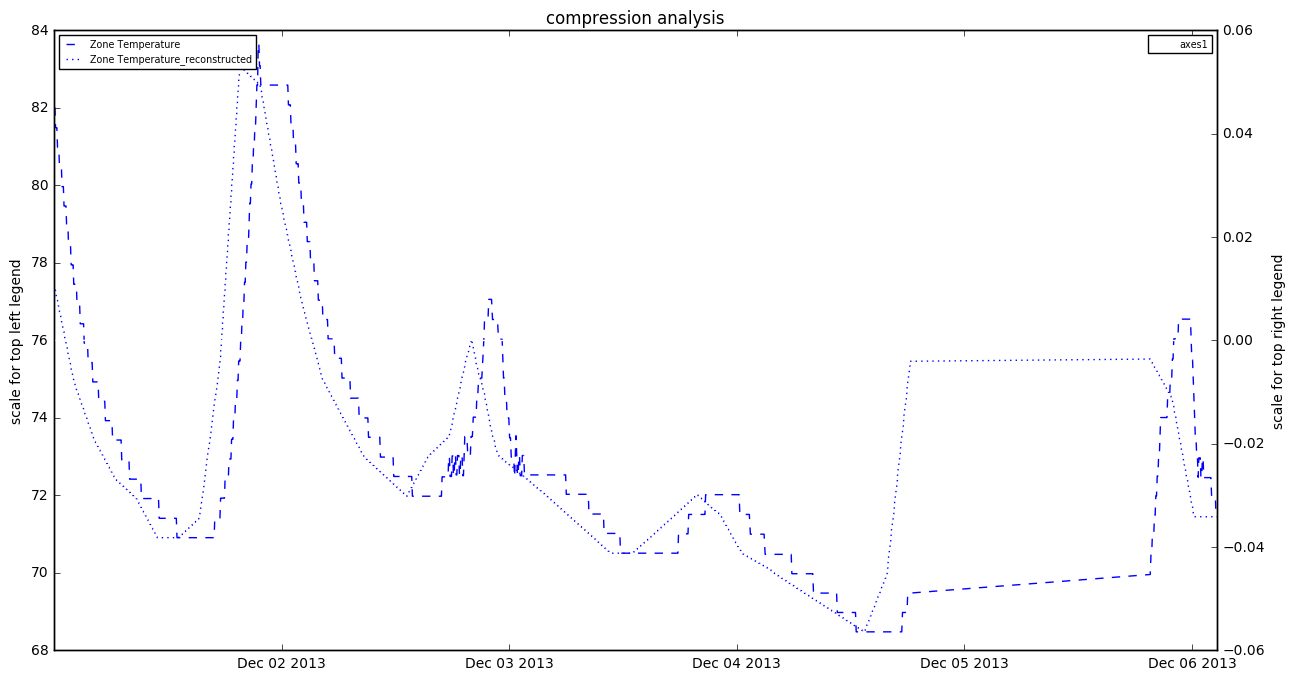

In [64]:
[dfs,plotTemplates]=runAnalysis(table='rm4226',stTime='2013-12-01',enTime='2013-12-07',templateCount=1)
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [75]:
dfs=runAnalysisOld('Rm-2219','Zone Temperature','2014-10-10T23:01:45+00:00','2014-10-24T23:59:18+00:00','piecewise_constant',tolerance=96)

109
Std dev is  1.91775064281
range= 5.72


C:\Users\rajeshb\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


type is  <class 'pandas.core.series.Series'>
size= 2 error= 0.177448401792 error/_std= 0.0925294445643
[{'value': 76.4252, 'time': 83}, {'value': 75.29542168674695, 'time': 0}]


select * from rm2138 where template='Zone Temperature' and timeseries between '2013-12-01' and '2013-12-07'
Std dev is  nan
rajeshb Zone Temperature
select * from rm2138 where template='Actual Supply Flow' and timeseries between '2013-12-01' and '2013-12-07'
Std dev is  116.768195462
range= 560.39


C:\Users\rajeshb\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


type is  <class 'pandas.core.series.Series'>
size= 71 error= 0.129878071229 error/_std= 0.00111227265879
[{'value': 168.33117647058825, 'time': 4863}, {'value': 270.64, 'time': 4860}, {'value': 415.5800000000002, 'time': 4839}, {'value': 528.6576470588235, 'time': 4788}, {'value': 279.29, 'time': 4785}, {'value': 172.79031250000003, 'time': 4689}, {'value': 170.31843749999982, 'time': 4593}, {'value': 171.26843749999992, 'time': 4497}, {'value': 168.59916666666672, 'time': 4425}, {'value': 22.6115, 'time': 4365}, {'value': 18.18374999999999, 'time': 4293}, {'value': 19.397499999999994, 'time': 4197}, {'value': 18.864666666666665, 'time': 4107}, {'value': 27.547826086956533, 'time': 4038}, {'value': 158.68363636363637, 'time': 4005}, {'value': 168.05593750000003, 'time': 3909}, {'value': 265.3344444444445, 'time': 3882}, {'value': 349.25869565217386, 'time': 3813}, {'value': 277.25, 'time': 3801}, {'value': 173.31124999999986, 'time': 3729}, {'value': 163.83653846153854, 'time': 3651}, 

C:\Users\rajeshb\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


axes0Count 0


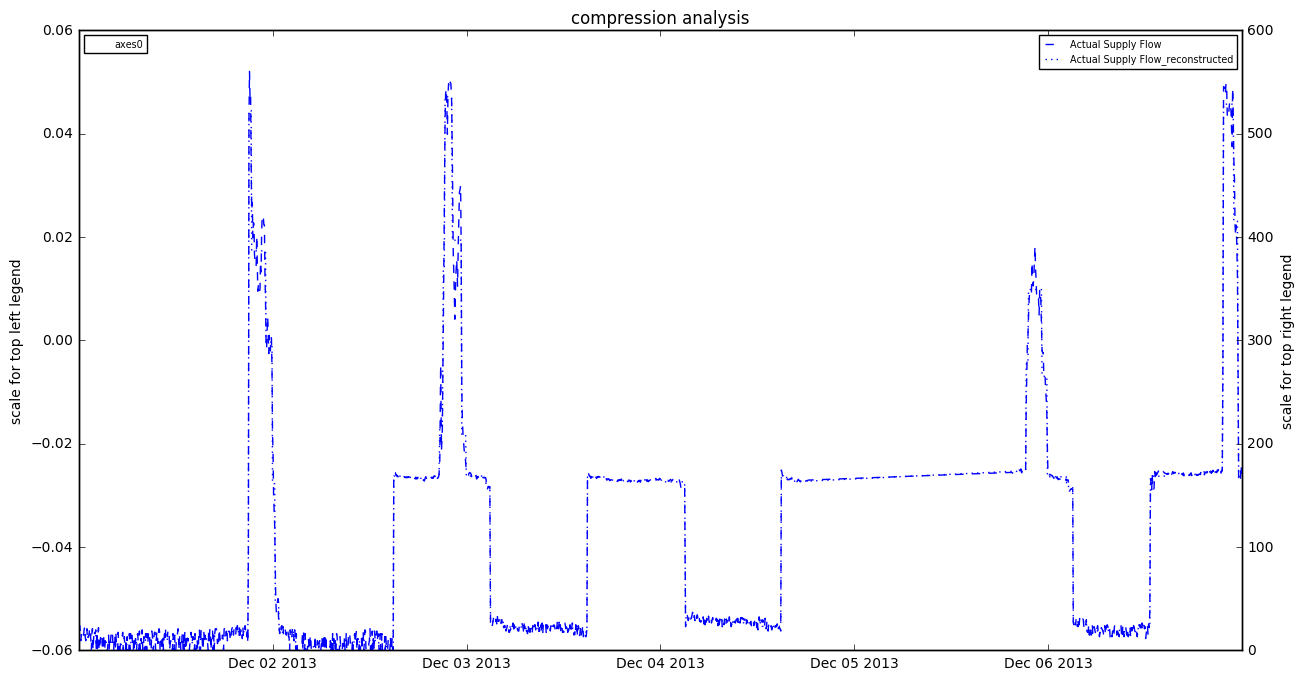

In [70]:
[dfs,plotTemplates]=runAnalysis(table='rm2138',stTime='2013-12-01',enTime='2013-12-07', templateCount=5)
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm3214',stTime='2014-02-10',enTime='2014-02-20',templateCount=17)
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm2234',stTime='2014-01-20',enTime='2014-01-30',templateCount=17)
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm3208',stTime='2014-03-20',enTime='2014-03-30',templateCount=17)
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm3214',stTime='2014-02-10',enTime='2014-02-20',templateCount=17)
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm2138',stTime='2014-04-07',enTime='2014-04-14',templateCount=17)
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm2118',stTime='2013-07-01',enTime='2013-07-10',templateCount=17)
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm4226',stTime='2014-03-01',enTime='2014-03-07')
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm2118',stTime='2013-12-01',enTime='2013-12-10',templateCount=17)
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm2118',stTime='2014-06-01',enTime='2014-06-10',templateCount=17)
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm2118',stTime='2014-12-01',enTime='2014-12-10',templateCount=17)
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm2118',stTime='2015-04-01',enTime='2015-04-10',templateCount=17)
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm4226',stTime='2013-07-01',enTime='2013-07-07')
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
[dfs,plotTemplates]=runAnalysis(table='rm2138',stTime='2013-07-01',enTime='2013-07-07')
print len(dfs)
print plotTemplates
plotResults(dfs,plotTemplates)

In [ ]:
#get summary table
df=hiveContext.sql("select * from dataSummary");
summaryDF=pd.DataFrame(df.collect(),columns=['room','template','stTime','enTime'])
summaryDF.head()

In [ ]:
#df=loadf('RF2','Current','2013-07-01','2013-07-14')
df['timeseries']=df['timeseries'].apply(lambda x:datetime.strptime(x, '%Y-%m-%dT%H:%M:%S+00:00'))
df.head()

In [ ]:
dfs=runAnalysis('RF2','Current','2013-07-01','2013-07-14','piecewise_constant',tolerance=16)
plotResults(dfs,'Current')

In [ ]:
dfs=runAnalysisOld('RM-1125','Actual Heating Setpoint','2015-02-01T00:00:00+00:00','2015-02-14T00:00:00+00:00','piecewise_constant',tolerance=16)

In [ ]:
dfs=runAnalysis('RM-1125','Actual Heating Setpoint','2015-02-01T00:00:00+00:00','2015-02-14T00:00:00+00:00','piecewise_constant',tolerance=16)
plotResults(dfs,'Actual Heating Setpoint')

In [ ]:
dfs=runAnalysisOld('Rm-2219','Zone Temperature','2014-10-10T23:01:45+00:00','2014-10-24T23:59:18+00:00','piecewise_constant',tolerance=96)

In [ ]:
dfs=runAnalysis('Rm-2219','Zone Temperature','2014-10-10T23:01:45+00:00','2014-10-24T23:59:18+00:00','piecewise_constant',tolerance=96)
plotResults(dfs,'Zone Temperature')

In [ ]:
dfs=runAnalysisOld('Rm-2150','Actual Cooling Setpoint','2015-02-01T00:00:00+00:00','2015-02-14T00:00:00+00:00','piecewise_constant',tolerance=96)

In [ ]:
dfs=runAnalysis('Rm-2150','Actual Cooling Setpoint','2015-02-01T00:00:00+00:00','2015-02-14T00:00:00+00:00','piecewise_constant',tolerance=96)
plotResults(dfs,'Actual Cooling Setpoint')

In [ ]:
dfs=runAnalysis('Rm-2109','Warm Cool Adjust','2014-03-01T00:00:00+00:00','2014-03-14T00:00:00+00:00','piecewise_constant',tolerance=96)
plotResults(dfs,'Warm Cool Adjust')

In [ ]:
dfs=runAnalysis('RM-1145','Common Setpoint','2014-12-01T00:00:00+00:00','2014-12-14T00:00:00+00:00','piecewise_constant',tolerance=36)
plotResults(dfs,'Common Setpoint')

In [ ]:
dfs=runAnalysisOld('RM-B260','Damper Position','2014-12-01T00:00:00+00:00','2014-12-14T00:00:00+00:00','piecewise_constant',tolerance=36)

In [ ]:
dfs=runAnalysis('RM-B260','Damper Position','2014-12-01T00:00:00+00:00','2014-12-14T00:00:00+00:00','piecewise_constant',tolerance=36)
plotResults(dfs,'Damper Position')

In [ ]:
dfs=runAnalysisOld('RM-1106','Actual Sup Flow SP','2014-08-01T00:00:00+00:00','2014-08-14T00:00:00+00:00','piecewise_constant',tolerance=96)

In [ ]:
dfs=runAnalysis('RM-1106','Actual Sup Flow SP','2014-08-01T00:00:00+00:00','2014-08-14T00:00:00+00:00','piecewise_constant',tolerance=96)
plotResults(dfs,'Actual Sup Flow SP')

In [ ]:
dfs=runAnalysisOld('Rm-4127','Actual Supply Flow','2015-02-01T00:00:00+00:00','2015-02-14T00:00:00+00:00','piecewise_constant',tolerance=16)

In [ ]:
dfs=runAnalysis('Rm-4127','Actual Supply Flow','2015-02-01T00:00:00+00:00','2015-02-14T00:00:00+00:00','piecewise_constant',tolerance=16)
plotResults(dfs,'Actual Supply Flow')

In [ ]:
dfs=runAnalysis('Rm-3146','Supply Vel Press','2014-02-01T00:00:00+00:00','2014-02-14T00:00:00+00:00','piecewise_constant',tolerance=16)
plotResults(dfs,'Supply Vel Press')

In [ ]:
dfs=runAnalysis('Rm-3213','Damper Command','2015-02-01T00:00:00+00:00','2015-02-14T00:00:00+00:00','piecewise_constant',tolerance=96)
plotResults(dfs,'Damper Command')

In [ ]:
dfs=runAnalysis('Rm-4127','Actual Supply Flow','2015-02-01T00:00:00+00:00','2015-02-14T00:00:00+00:00','piecewise_constant',tolerance=96)
plotResults(dfs,'Actual Supply Flow')

In [ ]:
#dfs=runAnalysis('HW-SYS','2015','2015-03-01 08:00:00','2015-03-08 17:30:00','piecewise_constant')
#df=loadf('HW-SYS','2015')
#subDF=dataPlot(df,'2015-03-01 08:00:00','2015-03-08 17:30:00')
#pd_df=subDF
#S=pd_df['values']
#_std=np.std(S)
#print "Std dev is ",_std

minErrorGap=10
minError=1e20
errors=[]
for maxGap in xrange(10,100):
  encoder=piecewise_constant(S,maxGap)
  C=encoder.compress(S)
  error=encoder.compute_error(S,C)
  print error
  errors.append(error)
  if(error<minError):
    minError=error
    minErrorGap=maxGap
print minErrorGap
minError
#R=encoder.recon()
#compressed_df=pd.DataFrame(C)


In [ ]:
plt.plot(np.array(errors))
plt.title('errors vs max_gap')
display(fig)

In [ ]:
sortedErrorIndex=sorted(range(len(errors)), key=lambda k: errors[k])
print sortedErrorIndex[0:10]

In [ ]:
#Change variables here. general funtion signature is runAnalysis(room,year,startTime,endTime,method) where method can take 3 values-piecewise_constant, piecewise_linear, both. Return object is a list of dataframes in this order-spark dataframe of full data of the room for the given year. pandas dataframe of subset of above data within the given time range. pandas dataframe of the comressed data
dfs=runAnalysis('HW-SYS','2015','2015-03-01 08:00:00','2015-03-08 17:30:00','piecewise_constant',tolerance=36)
plotResults(dfs)

In [ ]:
dfs=runAnalysis('HW-SYS','2015','2015-03-01 08:00:00','2015-03-08 17:30:00','piecewise_constant',tolerance=9)
plotResults(dfs)

In [ ]:
dfs=runAnalysis('HW-SYS','2015','2015-03-01 08:00:00','2015-03-08 17:30:00','piecewise_linear',tolerance=9)
plotResults(dfs)

In [ ]:
#Plots for other rooms, times and methods are below

In [ ]:
dfs=runAnalysis('Rm-4126','2014','2014-12-01 08:00:00','2014-12-08 17:30:00','piecewise_constant',tolerance=96)
plotResults(dfs)

In [ ]:
dfs=runAnalysis('Rm-2154','2014','2014-12-01 08:00:00','2014-12-08 17:30:00','piecewise_constant',tolerance=40)
plotResults(dfs)

In [ ]:
dfs=runAnalysis('RM-1208B','2015','2015-03-01 08:00:00','2015-03-08 17:30:00','piecewise_constant',tolerance=96)
plotResults(dfs)

In [ ]:
dfs=runAnalysis('Rm-3152','2015','2015-03-01 08:00:00','2015-03-08 17:30:00','piecewise_constant',tolerance=96)
plotResults(dfs)

In [ ]:
dfs=runAnalysis('Rm-4130','2015','2015-03-01 08:00:00','2015-03-08 17:30:00','piecewise_constant',tolerance=96)
plotResults(dfs)